<div style="border:2px solid #3344ffff; padding:10px; border-radius:8px; overflow-x:auto; width:100%; box-sizing:border-box;">

<h1><center>Assignment 02</center></h1>
<h2>
Ayushman Anupam (MDS202411)
</h2>

</div>

In [146]:
# importing needed libraries

import os
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.metrics import average_precision_score
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, precision_score, recall_score, precision_recall_curve, auc

folder_path = "data"
# seed = 2, 9, 13, 42, 123
split_random_seed = 123 # reandom seed used for splitting data


In [147]:
# Adding ML flow libraries

import mlflow
import mlflow.sklearn
from mlflow.tracking import MlflowClient

mlflow.set_experiment("Spam_Classification_Benchmarks")


<Experiment: artifact_location=('file:x:/AGDrive/Applied_Machine_Learning/Assignment 02 - Experiment '
 'Tracking/mlruns/1'), creation_time=1771354474669, experiment_id='1', last_update_time=1771354474669, lifecycle_stage='active', name='Spam_Classification_Benchmarks', tags={}>

In [148]:
train_df_path = os.path.join(folder_path, f"train_df_(seed={split_random_seed}).csv")
validation_df_path = os.path.join(folder_path, f"validation_df_(seed={split_random_seed}).csv")
test_df_path = os.path.join(folder_path, f"test_df_(seed={split_random_seed}).csv")

train_df = pd.read_csv(train_df_path)
test_df = pd.read_csv(test_df_path)
val_df = pd.read_csv(validation_df_path)

### **Creating needed helper function**

In [149]:
# function to get evaluation score
def evaluate_predictions(y_true, y_pred):
    print("Accuracy: ", round(accuracy_score(y_true, y_pred), 5))
    print("Precision:", round(precision_score(y_true, y_pred), 5))
    print("Recall:   ", round(recall_score(y_true, y_pred), 5))
    print("F1:       ", round(f1_score(y_true, y_pred), 5))

    p, r, _ = precision_recall_curve(y_true, y_pred, pos_label=1)
    print("PR AUC:   ", round(auc(r, p), 5))

# function to plot confusion martix and PR curve in 1x2 grid
def plot_pr_curve_and_confusion_matrix(y_true, y_pred, y_scores):
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Precision-Recall Curve
    p, r, _ = precision_recall_curve(y_true, y_scores, pos_label=1)
    axes[0].plot(r, p, label='Precision-Recall Curve')
    axes[0].set_xlabel('Recall')
    axes[0].set_ylabel('Precision')
    axes[0].set_title('Precision-Recall Curve')
    axes[0].legend()

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(
        cm,
        annot=True,
        cmap='Blues',
        fmt='d',
        xticklabels=['ham', 'spam'],
        yticklabels=['ham', 'spam'],
        ax=axes[1]
    )
    axes[1].set_title('Confusion Matrix')
    axes[1].set_xlabel('Predicted Labels')
    axes[1].set_ylabel('True Labels')

    plt.tight_layout()
    plt.show()

# function to plot confusion matrix for all model in 1x3 grid
def plot_confusion_matrices(models, model_names, X, y):
    n_models = len(models)
    fig, axes = plt.subplots(1, n_models, figsize=(5 * n_models, 4))

    if n_models == 1:
        axes = [axes] 

    for i, model in enumerate(models):
        y_pred = model.predict(X)
        cm = confusion_matrix(y, y_pred)

        sns.heatmap(
            cm,
            annot=True,
            fmt='d',
            cmap='Blues',
            xticklabels=['ham', 'spam'],
            yticklabels=['ham', 'spam'],
            ax=axes[i]
        )

        axes[i].set_title(model_names[i])
        axes[i].set_xlabel('Predicted')
        axes[i].set_ylabel('True')

    plt.tight_layout()
    plt.show()

# function to plot P-R curve for all model in 1x3 grid
def plot_pr_auc_curves(models, model_names, X, y):
    n_models = len(models)
    fig, axes = plt.subplots(1, n_models, figsize=(5 * n_models, 4))

    if n_models == 1:
        axes = [axes]

    for i, model in enumerate(models):
        y_scores = model.predict_proba(X)[:, 1]
        precision, recall, _ = precision_recall_curve(y, y_scores)
        pr_auc = auc(recall, precision)

        axes[i].plot(recall, precision, label=f'PR AUC = {pr_auc:.5f}')
        axes[i].set_title(model_names[i])
        axes[i].set_xlabel('Recall')
        axes[i].set_ylabel('Precision')
        axes[i].legend()

    plt.tight_layout()
    plt.show()

# function to evaluation all 3 models
def benchmark_models(models, model_names, X_test, y_test):
    df = pd.DataFrame(
        np.zeros((len(models), 5)),
        index=model_names,
        columns=["Accuracy", "Precision", "Recall", "F1-score", "PR-AUC"]
    )

    for i, model in enumerate(models):
        y_pred = model.predict(X_test)
        y_scores = model.predict_proba(X_test)[:, 1]

        df.iloc[i, 0] = accuracy_score(y_test, y_pred)
        df.iloc[i, 1] = precision_score(y_test, y_pred)
        df.iloc[i, 2] = recall_score(y_test, y_pred)
        df.iloc[i, 3] = f1_score(y_test, y_pred)
        p, r, _ = precision_recall_curve(y_test, y_scores)
        df.iloc[i, 4] = auc(r, p)

    return df.round(5)

# function to plot histogram of all evaluation matrices for all model in 1x3 and 1x2 grid
def plot_benchmark_histograms(benchmark_df):
    colors = {
        "Naive Bayes": "tab:blue",
        "Logistic Regression": "tab:orange",
        "Random Forest": "tab:green"
    }

    models = benchmark_df.index

    # 1x3 grid: Accuracy, Precision, Recall
    metrics_1 = ["Accuracy", "Precision", "Recall"]
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    for i, metric in enumerate(metrics_1):
        for model in models:
            axes[i].bar(
                model,
                benchmark_df.loc[model, metric],
                color=colors[model]
            )
        axes[i].set_title(metric)
        axes[i].set_ylim(0.9, 1.015)
        axes[i].set_ylabel("Score")

    plt.tight_layout()
    plt.show()

    # 1x2 grid: F1-score, PR-AUC
    metrics_2 = ["F1-score", "PR-AUC"]
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    for i, metric in enumerate(metrics_2):
        for model in models:
            axes[i].bar(
                model,
                benchmark_df.loc[model, metric],
                color=colors[model]
            )
        axes[i].set_title(metric)
        axes[i].set_ylim(0.9, 1.015)
        axes[i].set_ylabel("Score")

    plt.tight_layout()
    plt.show()


## Model Selection

In this project, I used 3 machine learning models for spam/ham classification and each of model is evaluated using standard metrices like Accuracy, Precision, Recall, F1-score and Area under the Precision-Recall respectively.

1. Naive Bayes
2. Logistic Regression
3. Random Forest Classifier

## **1. Naive Bayes Classifier**

In [150]:
# Hyper-parameters of Naive Bayes
print(MultinomialNB().get_params()) # Multinomial Naive Bayes

{'alpha': 1.0, 'class_prior': None, 'fit_prior': True, 'force_alpha': True}


In [151]:
nb_model = Pipeline([
    ('bow', CountVectorizer()),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

nb_model.fit(train_df['message'], train_df['label'])

Pipeline(steps=[('bow', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('classifier', MultinomialNB())])

### **Performance on training data**

Accuracy:  0.97949
Precision: 1.0
Recall:    0.84283
F1:        0.91471
PR AUC:    0.93167


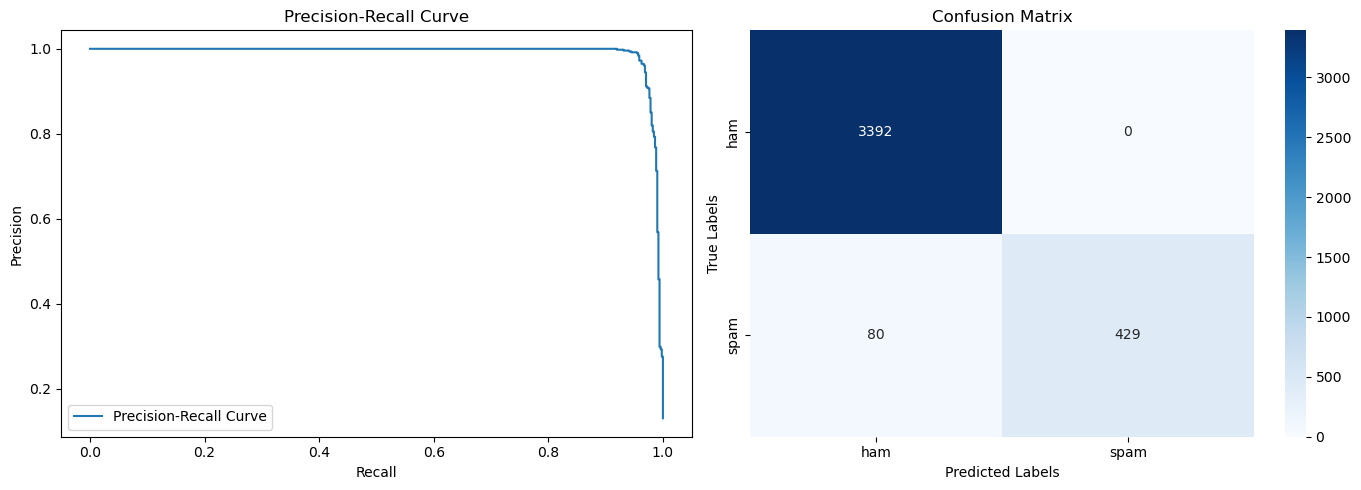

In [152]:
nb_prediction = nb_model.predict(train_df['message'])
nb_scores = nb_model.predict_proba(train_df['message'])[:, 1]

evaluate_predictions(train_df['label'], nb_prediction)
plot_pr_curve_and_confusion_matrix(
    train_df['label'],
    nb_prediction,
    nb_scores
)


### **Performance on validation data**

Accuracy:  0.9722
Precision: 1.0
Recall:    0.81098
F1:        0.89562
PR AUC:    0.91939


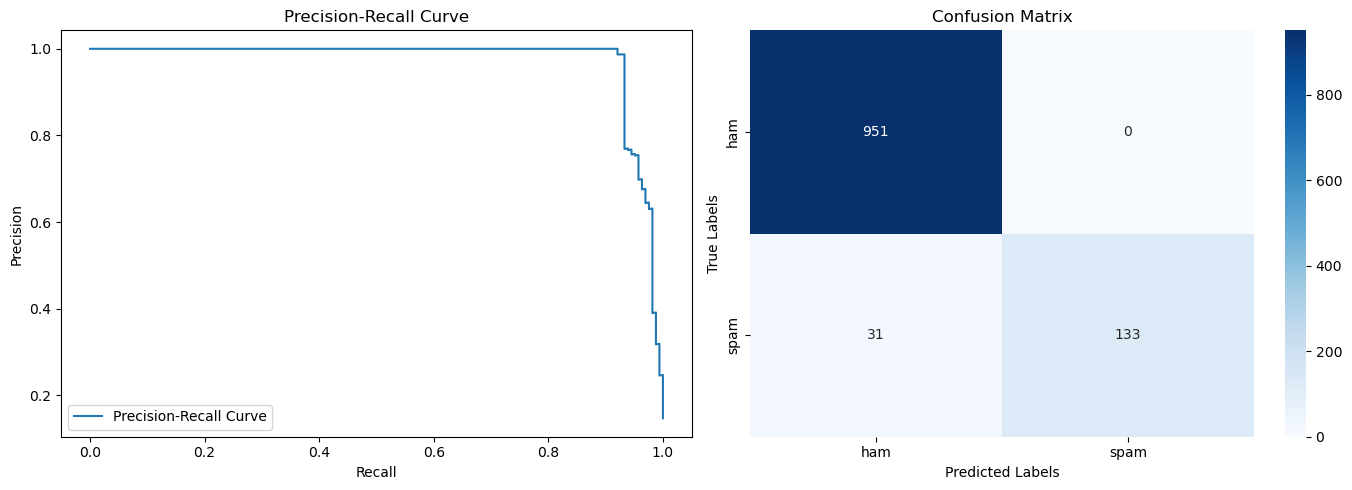

In [153]:
nb_prediction = nb_model.predict(val_df['message'])
nb_scores = nb_model.predict_proba(val_df['message'])[:, 1]

evaluate_predictions(val_df['label'], nb_prediction)
plot_pr_curve_and_confusion_matrix(
    val_df['label'],
    nb_prediction,
    nb_scores
)


### **Hyperparameter tuning of NaiveBayes**

In [154]:
param_grid = {
    'classifier__alpha': [0.05, 0.1, 0.5, 1],
    'classifier__fit_prior': [True, False],
}

NB_model = GridSearchCV(nb_model, 
                        param_grid, 
                        cv=5, 
                        scoring='f1', 
                        verbose=1, 
                        n_jobs=-1)
NB_model.fit(train_df['message'], train_df['label'])

Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('bow', CountVectorizer()),
                                       ('tfidf', TfidfTransformer()),
                                       ('classifier', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'classifier__alpha': [0.05, 0.1, 0.5, 1],
                         'classifier__fit_prior': [True, False]},
             scoring='f1', verbose=1)

In [155]:
print("Best parameters:", NB_model.best_params_)
print("Best f1 score:", NB_model.best_score_)

Best parameters: {'classifier__alpha': 0.1, 'classifier__fit_prior': True}
Best f1 score: 0.931679926758601


## **Log Naive Bayes**

In [156]:
with mlflow.start_run(run_name=f"Naive_Bayes_seed_{split_random_seed}"):

    model = NB_model.best_estimator_

    val_scores = model.predict_proba(val_df['message'])[:, 1]
    aucpr = average_precision_score(val_df['label'], val_scores)

    mlflow.log_param("model_type", "NaiveBayes")
    mlflow.log_param("split_seed", split_random_seed)
    mlflow.log_params(NB_model.best_params_)
    mlflow.log_metric("AUCPR", aucpr)

    mlflow.sklearn.log_model(
        model,
        artifact_path="model",
        registered_model_name="SpamClassifier"
    )

    print(f"Seed: {split_random_seed} | NaiveBayes AUCPR: {aucpr}")

2026/02/18 00:31:03 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
c:\Users\ayush\anaconda3\Lib\site-packages\mlflow\models\model.py:1209: FutureWarning: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is the 'skops' format.
  flavor.save_model(path=local_path, mlflow_model=mlflow_model, **kwargs)


Seed: 123 | NaiveBayes AUCPR: 0.9821585310264884


Registered model 'SpamClassifier' already exists. Creating a new version of this model...
Created version '9' of model 'SpamClassifier'.


### **Performance on training data**

Accuracy:  0.99821
Precision: 0.99802
Recall:    0.98821
F1:        0.99309
PR AUC:    0.99388


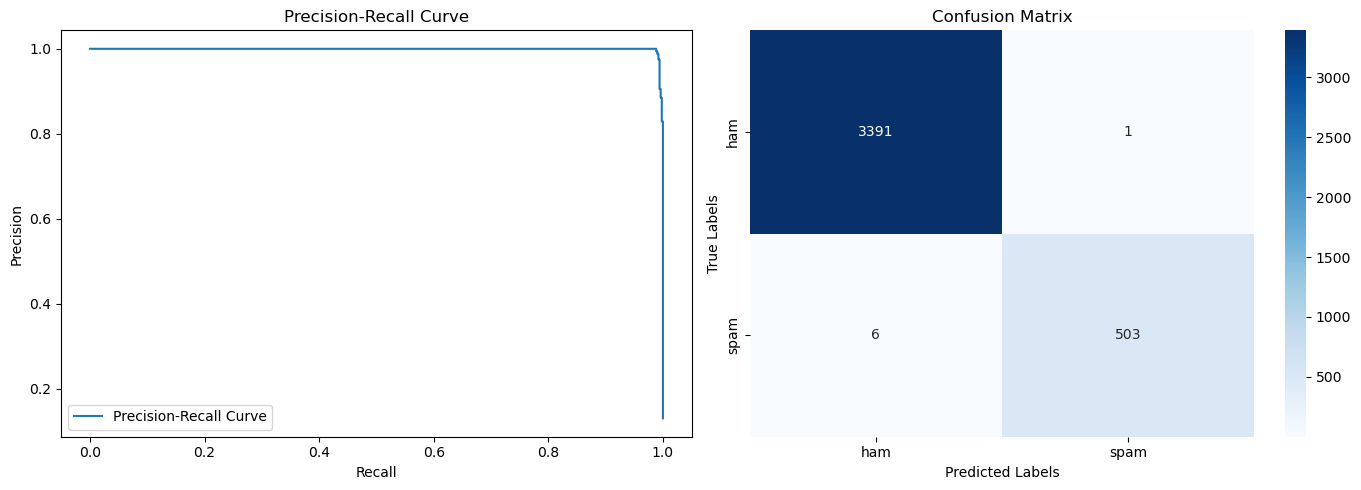

In [157]:
nb_prediction = NB_model.predict(train_df['message'])
nb_scores = NB_model.predict_proba(train_df['message'])[:, 1]

evaluate_predictions(train_df['label'], nb_prediction)
plot_pr_curve_and_confusion_matrix(
    train_df['label'],
    nb_prediction,
    nb_scores
)


### **Performance on Validation data**

Accuracy:  0.98924
Precision: 0.99351
Recall:    0.93293
F1:        0.96226
PR AUC:    0.96815


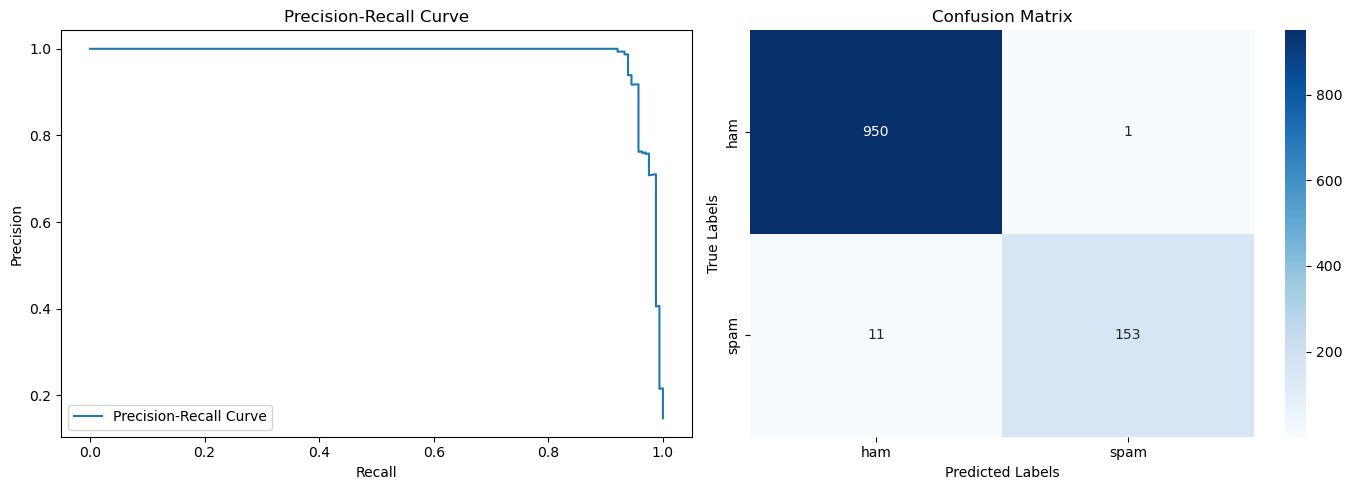

In [158]:
nb_prediction = NB_model.predict(val_df['message'])
nb_scores = NB_model.predict_proba(val_df['message'])[:, 1]

evaluate_predictions(val_df['label'], nb_prediction)
plot_pr_curve_and_confusion_matrix(
    val_df['label'],
    nb_prediction,
    nb_scores
)


## **2. Logistic Regresion Classifier**

In [159]:
# Hyperparameters of logistice regression
LogisticRegression().get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'deprecated',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [160]:
# defining model
lr_model = Pipeline([
    ('bow', CountVectorizer()),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', LogisticRegression(random_state=42, max_iter=500))  # train on TF-IDF vectors w/ logistic regression
])

# training model on train set
lr_model.fit(train_df['message'], train_df['label'])

Pipeline(steps=[('bow', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('classifier',
                 LogisticRegression(max_iter=500, random_state=42))])

### **Performance on training data**

Accuracy:  0.96873
Precision: 0.98987
Recall:    0.76817
F1:        0.86504
PR AUC:    0.89415


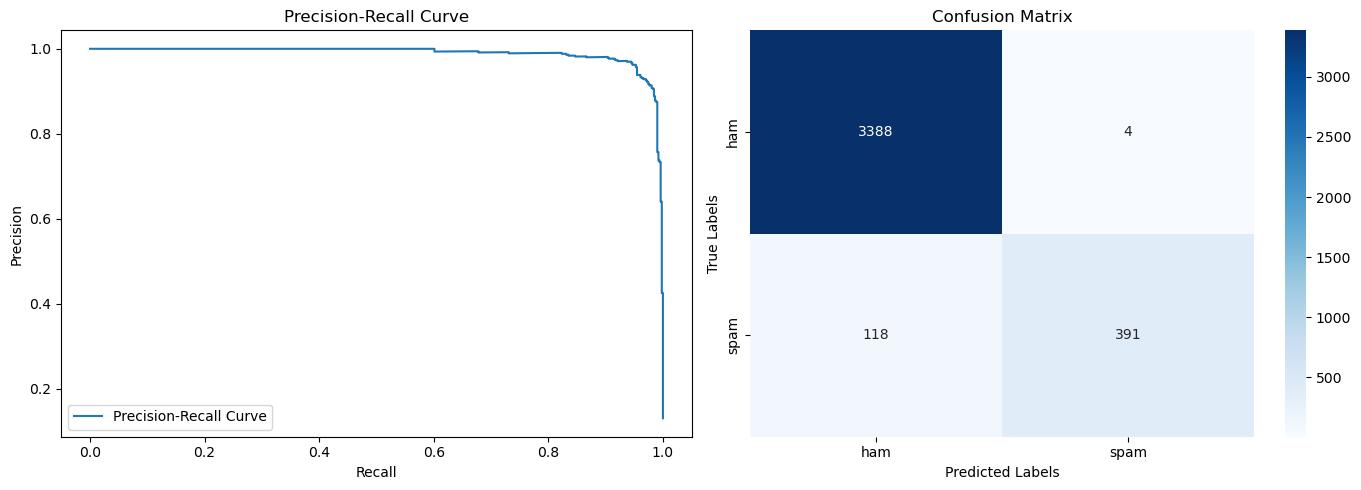

In [161]:
lr_prediction = lr_model.predict(train_df['message'])
lr_scores = lr_model.predict_proba(train_df['message'])[:, 1]

evaluate_predictions(train_df['label'], lr_prediction)
plot_pr_curve_and_confusion_matrix(
    train_df['label'],
    lr_prediction,
    lr_scores
)


### **Performance on Validation data**

Accuracy:  0.96951
Precision: 0.99242
Recall:    0.79878
F1:        0.88514
PR AUC:    0.9104


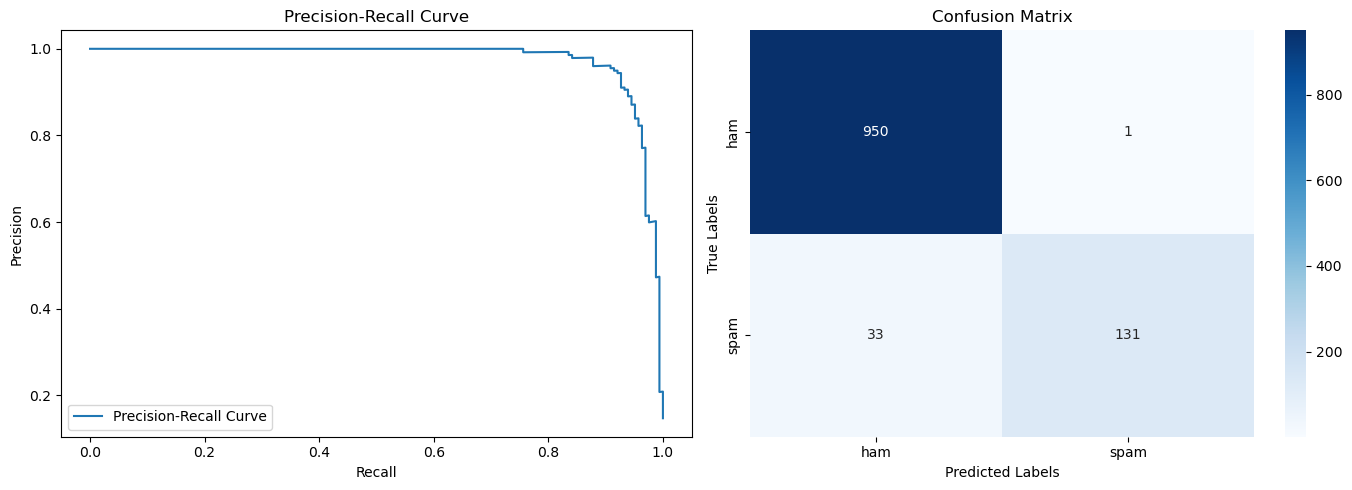

In [162]:
lr_prediction = lr_model.predict(val_df['message'])
lr_scores = lr_model.predict_proba(val_df['message'])[:, 1]

evaluate_predictions(val_df['label'], lr_prediction)
plot_pr_curve_and_confusion_matrix(
    val_df['label'],
    lr_prediction,
    lr_scores
)


## **Hyperparameter Tuning**

In [163]:
param_grid = {
    'classifier__C': [1, 5, 10, 25, 50],
    'classifier__class_weight': [None, 'balanced']
}

LR_model = GridSearchCV(
    lr_model,
    param_grid,
    cv=5,
    scoring='f1',
    verbose=1,
    n_jobs=-1
)

LR_model.fit(train_df['message'], train_df['label'])

Fitting 5 folds for each of 10 candidates, totalling 50 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('bow', CountVectorizer()),
                                       ('tfidf', TfidfTransformer()),
                                       ('classifier',
                                        LogisticRegression(max_iter=500,
                                                           random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__C': [1, 5, 10, 25, 50],
                         'classifier__class_weight': [None, 'balanced']},
             scoring='f1', verbose=1)

In [164]:
print("Best parameters:", LR_model.best_params_)
print("Best CV F1 score:", LR_model.best_score_)

Best parameters: {'classifier__C': 10, 'classifier__class_weight': 'balanced'}
Best CV F1 score: 0.9381858409789444


## **Log Logistic Regression**

In [165]:
with mlflow.start_run(run_name=f"Logistic_Regression_seed_{split_random_seed}"):

    model = LR_model.best_estimator_

    val_scores = model.predict_proba(val_df['message'])[:, 1]
    aucpr = average_precision_score(val_df['label'], val_scores)

    mlflow.log_param("model_type", "LogisticRegression")
    mlflow.log_param("split_seed", split_random_seed)
    mlflow.log_params(LR_model.best_params_)
    mlflow.log_metric("AUCPR", aucpr)

    mlflow.sklearn.log_model(
        model,
        artifact_path="model",
        registered_model_name="SpamClassifier"
    )

    print(f"Seed: {split_random_seed} | LogisticRegression AUCPR: {aucpr}")


2026/02/18 00:31:13 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
c:\Users\ayush\anaconda3\Lib\site-packages\mlflow\models\model.py:1209: FutureWarning: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is the 'skops' format.
  flavor.save_model(path=local_path, mlflow_model=mlflow_model, **kwargs)


Seed: 123 | LogisticRegression AUCPR: 0.9821824800538023


Registered model 'SpamClassifier' already exists. Creating a new version of this model...
Created version '10' of model 'SpamClassifier'.


### **Performance on training data**

Accuracy:  0.99795
Precision: 0.98453
Recall:    1.0
F1:        0.9922
PR AUC:    0.99226


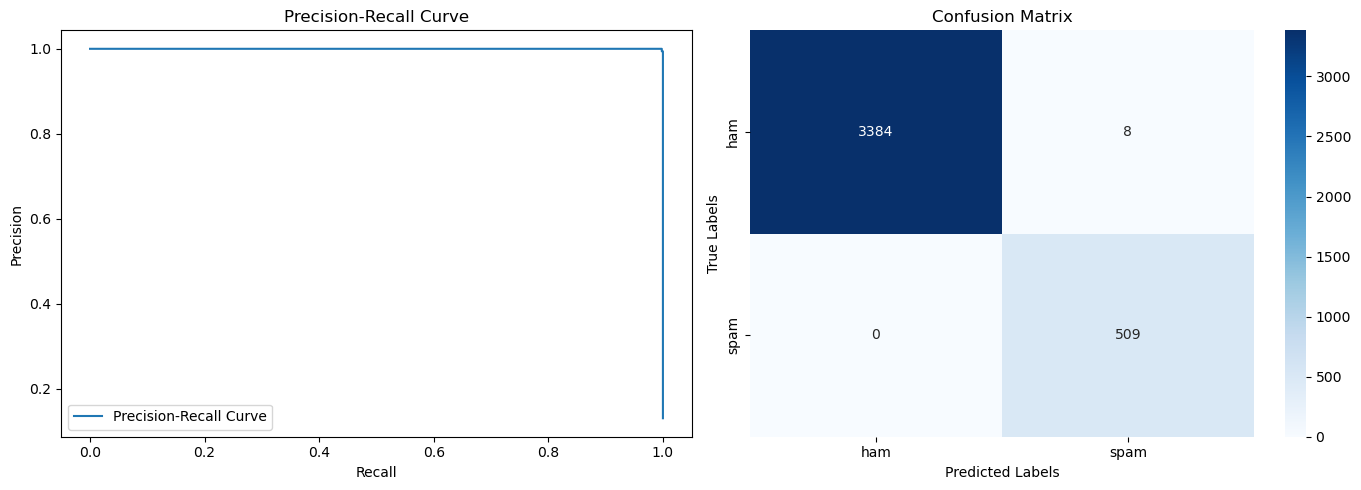

In [166]:
lr_prediction = LR_model.predict(train_df['message'])
lr_scores = LR_model.predict_proba(train_df['message'])[:, 1]

evaluate_predictions(train_df['label'], lr_prediction)
plot_pr_curve_and_confusion_matrix(
    train_df['label'],
    lr_prediction,
    lr_scores
)


### **Performance on Validation data**

Accuracy:  0.98296
Precision: 0.93939
Recall:    0.94512
F1:        0.94225
PR AUC:    0.94629


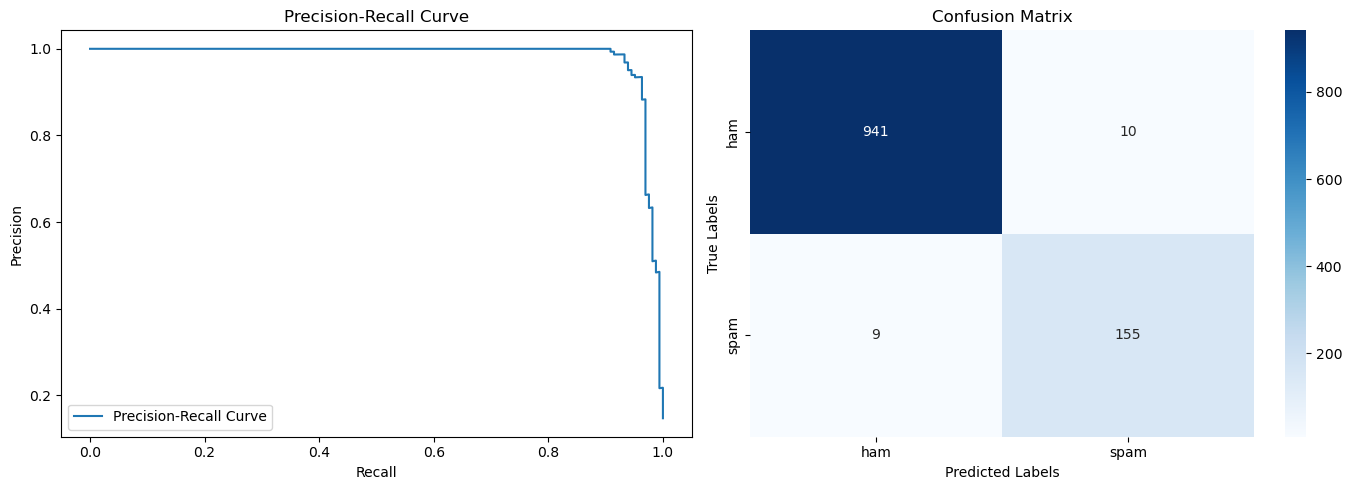

In [167]:
lr_prediction = LR_model.predict(val_df['message'])
lr_scores = LR_model.predict_proba(val_df['message'])[:, 1]

evaluate_predictions(val_df['label'], lr_prediction)
plot_pr_curve_and_confusion_matrix(
    val_df['label'],
    lr_prediction,
    lr_scores
)


## **3. Random Forest Classifier**

In [168]:
# Hyperparameters of RandomForest
RandomForestClassifier().get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [169]:
# defining model
rf_model = Pipeline([
    ('bow', CountVectorizer()),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', RandomForestClassifier( # train on TF-IDF vectors w/ SVM classifier
        n_estimators=400,
        random_state=42,
        n_jobs=-1))  
])

# training model on train set
rf_model.fit(train_df['message'], train_df['label'])

Pipeline(steps=[('bow', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('classifier',
                 RandomForestClassifier(n_estimators=400, n_jobs=-1,
                                        random_state=42))])

### **Performance on training data**

Accuracy:  1.0
Precision: 1.0
Recall:    1.0
F1:        1.0
PR AUC:    1.0


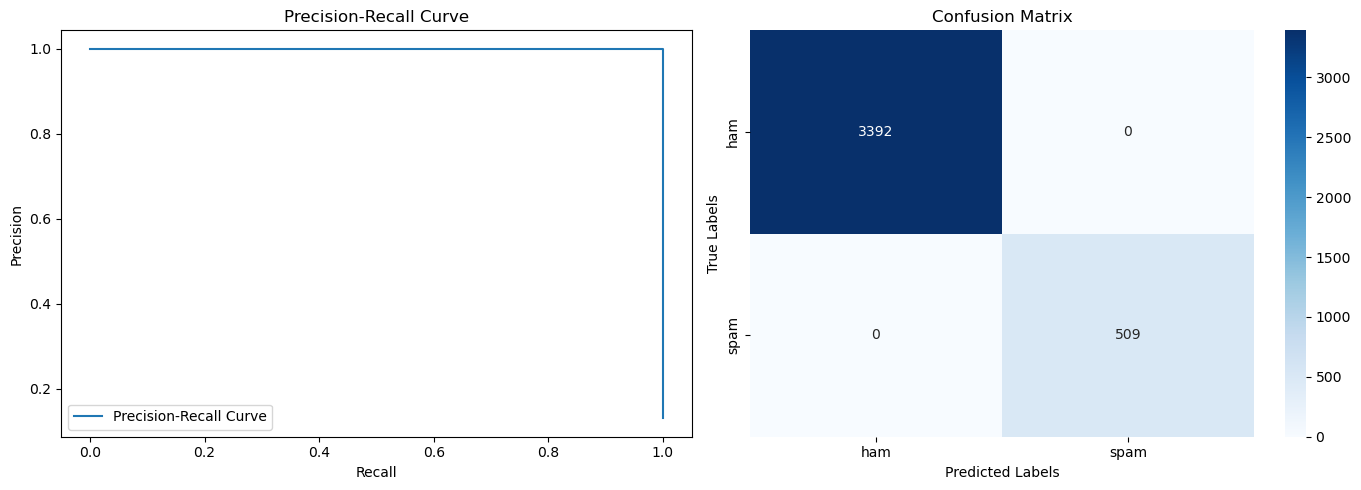

In [170]:
rf_prediction = rf_model.predict(train_df['message'])
rf_scores = rf_model.predict_proba(train_df['message'])[:, 1]

evaluate_predictions(train_df['label'], rf_prediction)
plot_pr_curve_and_confusion_matrix(
    train_df['label'],
    rf_prediction,
    rf_scores
)

### **Performance on Validation data**

Accuracy:  0.98206
Precision: 1.0
Recall:    0.87805
F1:        0.93506
PR AUC:    0.94799


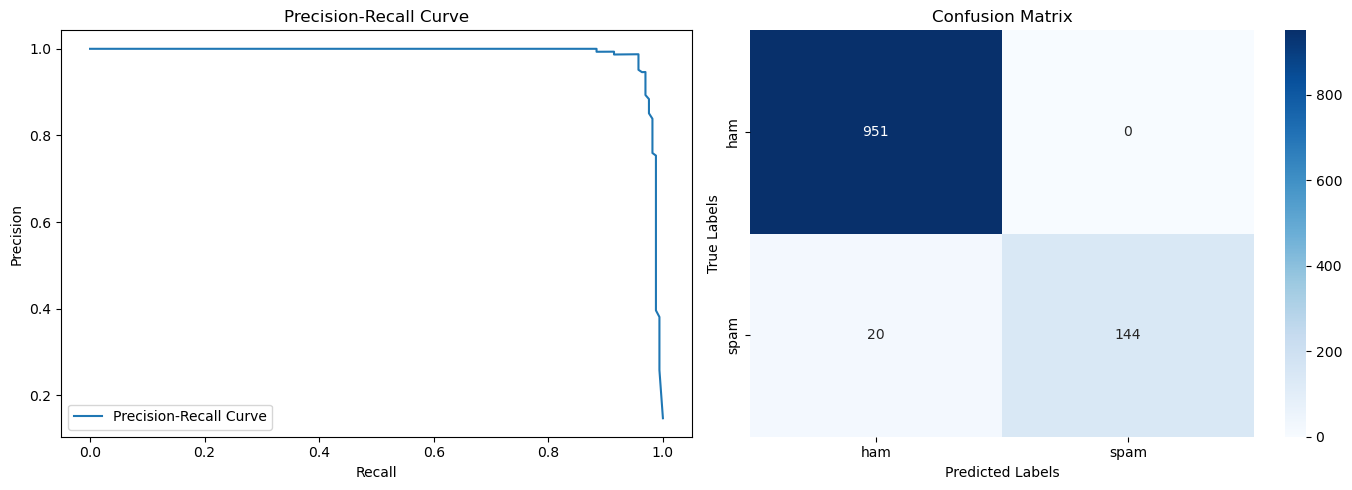

In [171]:
rf_prediction = rf_model.predict(val_df['message'])
rf_scores = rf_model.predict_proba(val_df['message'])[:, 1]

evaluate_predictions(val_df['label'], rf_prediction)
plot_pr_curve_and_confusion_matrix(
    val_df['label'],
    rf_prediction,
    rf_scores
)

In [172]:
param_grid = {
    # 'classifier__n_estimators': [200, 400],
    # 'classifier__max_depth': [None, 40, 60],
    'classifier__min_samples_split': [2, 5],
    'classifier__class_weight': [None, 'balanced']
}

RF_model = GridSearchCV(
    rf_model,
    param_grid,
    cv=5,
    scoring='f1',
    verbose=1,
    n_jobs=-1
)

RF_model.fit(train_df['message'], train_df['label'])

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('bow', CountVectorizer()),
                                       ('tfidf', TfidfTransformer()),
                                       ('classifier',
                                        RandomForestClassifier(n_estimators=400,
                                                               n_jobs=-1,
                                                               random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__class_weight': [None, 'balanced'],
                         'classifier__min_samples_split': [2, 5]},
             scoring='f1', verbose=1)

In [173]:
print("Best parameters:", RF_model.best_params_)
print("Best CV F1 score:", RF_model.best_score_)

Best parameters: {'classifier__class_weight': 'balanced', 'classifier__min_samples_split': 5}
Best CV F1 score: 0.9219586828956166


## **Log Random Forest Classifier**

In [174]:
with mlflow.start_run(run_name=f"Random_Forest_seed_{split_random_seed}"):

    model = RF_model.best_estimator_

    val_scores = model.predict_proba(val_df['message'])[:, 1]
    aucpr = average_precision_score(val_df['label'], val_scores)

    mlflow.log_param("model_type", "RandomForest")
    mlflow.log_param("split_seed", split_random_seed)
    mlflow.log_params(RF_model.best_params_)
    mlflow.log_metric("AUCPR", aucpr)

    # mlflow.sklearn.log_model(
    #     model,
    #     artifact_path="model",
    #     registered_model_name="SpamClassifier"
    # )

    print(f"Seed: {split_random_seed} | RandomForest AUCPR: {aucpr}")

Seed: 123 | RandomForest AUCPR: 0.9852797370668619


### **Performance on training data**

Accuracy:  1.0
Precision: 1.0
Recall:    1.0
F1:        1.0
PR AUC:    1.0


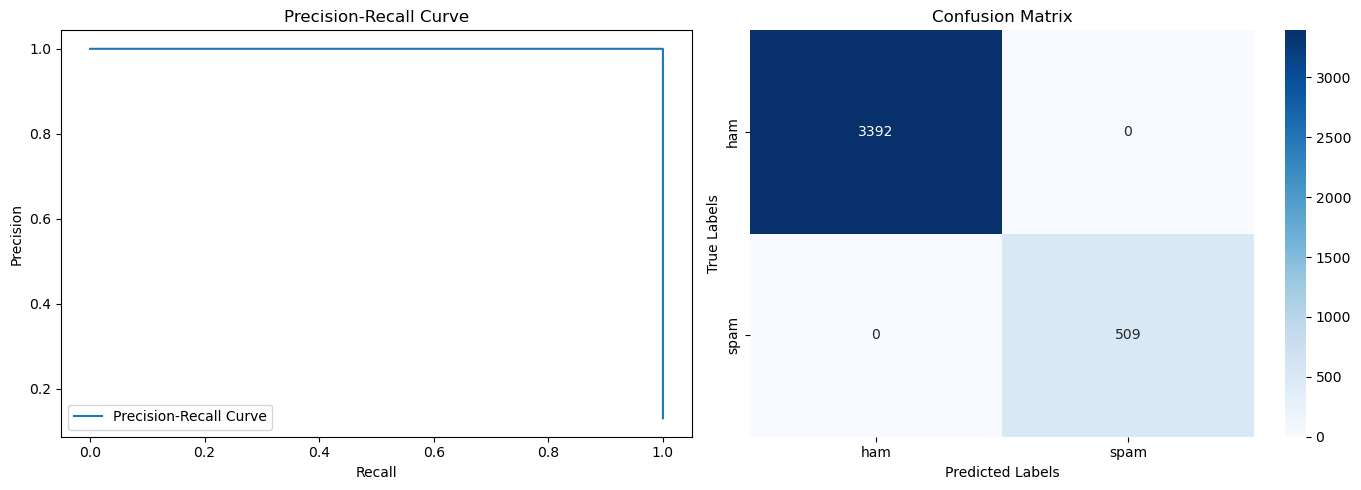

In [175]:
rf_prediction = RF_model.predict(train_df['message'])
rf_scores = RF_model.predict_proba(train_df['message'])[:, 1]

evaluate_predictions(train_df['label'], rf_prediction)
plot_pr_curve_and_confusion_matrix(
    train_df['label'],
    rf_prediction,
    rf_scores
)


### **Performance on Validation data**

Accuracy:  0.98386
Precision: 0.99324
Recall:    0.89634
F1:        0.94231
PR AUC:    0.95242


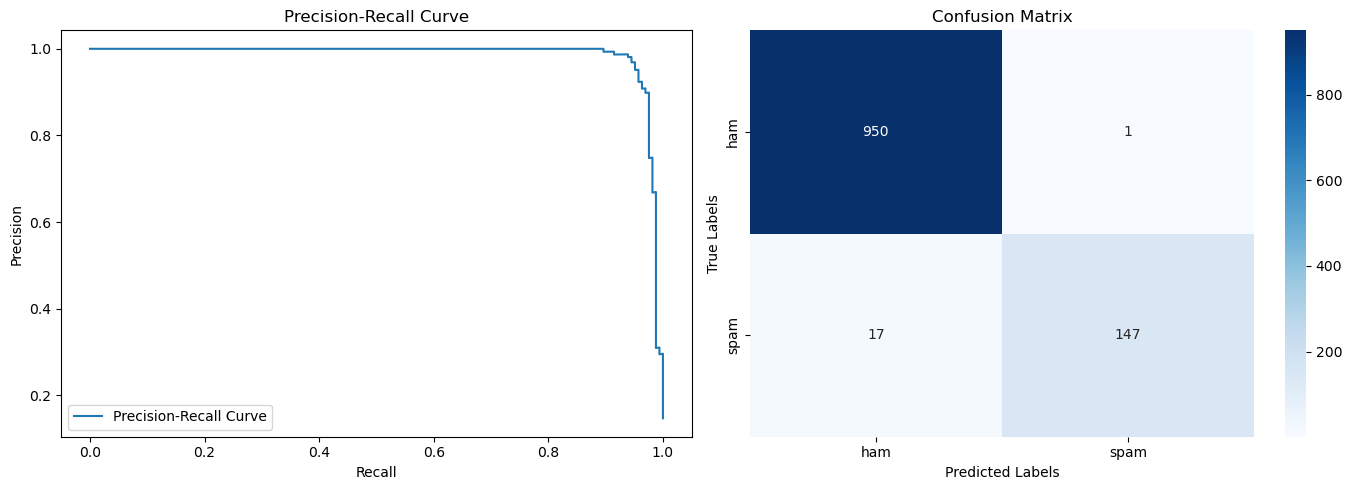

In [176]:
rf_prediction = RF_model.predict(val_df['message'])
rf_scores = RF_model.predict_proba(val_df['message'])[:, 1]

evaluate_predictions(val_df['label'], rf_prediction)
plot_pr_curve_and_confusion_matrix(
    val_df['label'],
    rf_prediction,
    rf_scores
)


# Testing all three models on the Test Data

In [177]:
models = [ NB_model.best_estimator_, LR_model.best_estimator_, RF_model.best_estimator_]
model_names = [ "Naive Bayes", "Logistic Regression", "Random Forest"]

benchmark_df = benchmark_models(
    models=models,
    model_names=model_names,
    X_test=test_df['message'],
    y_test=test_df['label']
)
benchmark_df


,Accuracy,Precision,Recall,F1-score,PR-AUC
Naive Bayes,0.98746,1.00000,0.90541,0.95035,0.97610
Logistic Regression,0.97849,0.93056,0.90541,0.91781,0.98474
Random Forest,0.98387,1.00000,0.87838,0.93525,0.99235


### **Confusion matrix and PR-AUC curve for all 3 models**

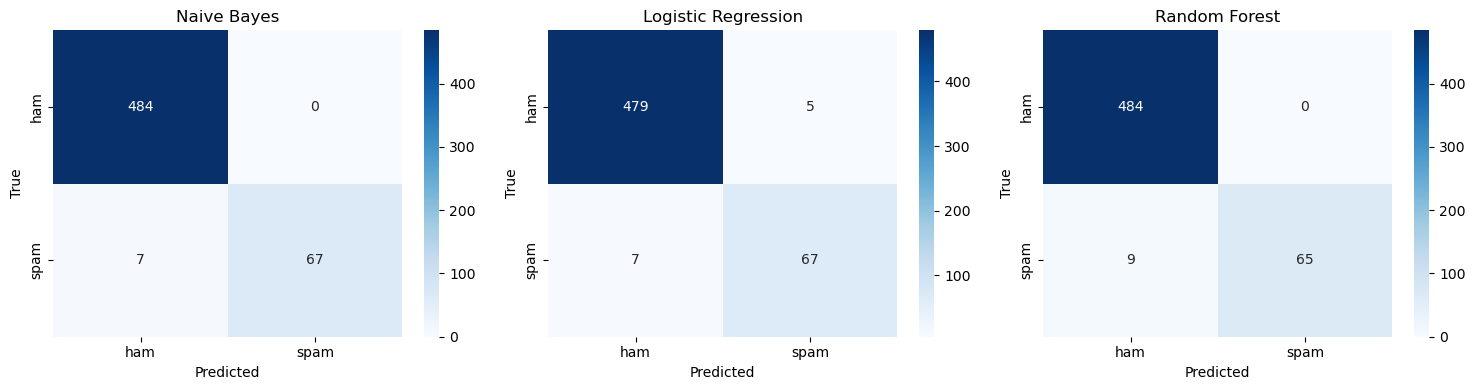

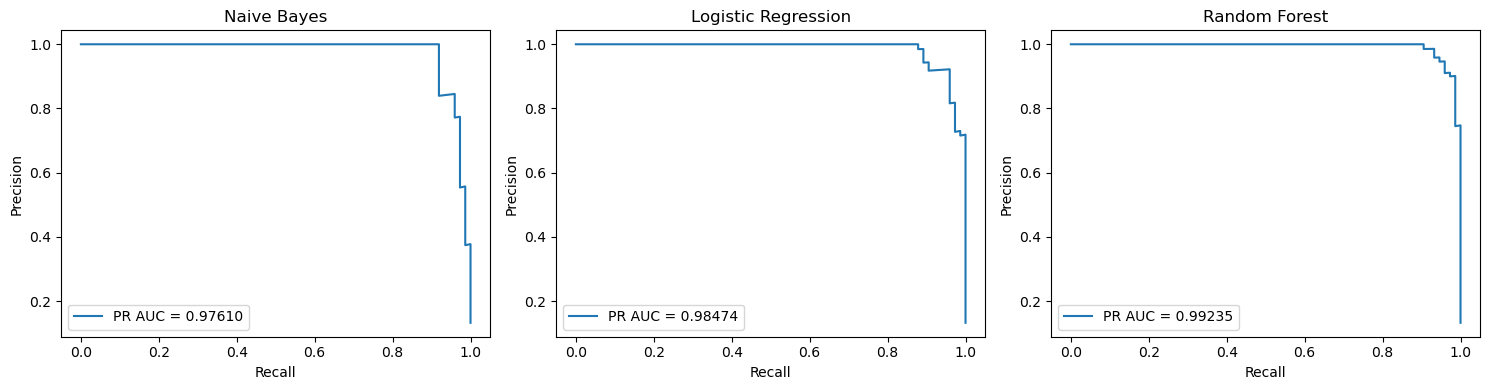

In [178]:
plot_confusion_matrices(
    models=models,
    model_names=model_names,
    X=test_df['message'],
    y=test_df['label']
)

plot_pr_auc_curves(
    models=models,
    model_names=model_names,
    X=test_df['message'],
    y=test_df['label']
)

### **Evaluation matices for all 3 models**

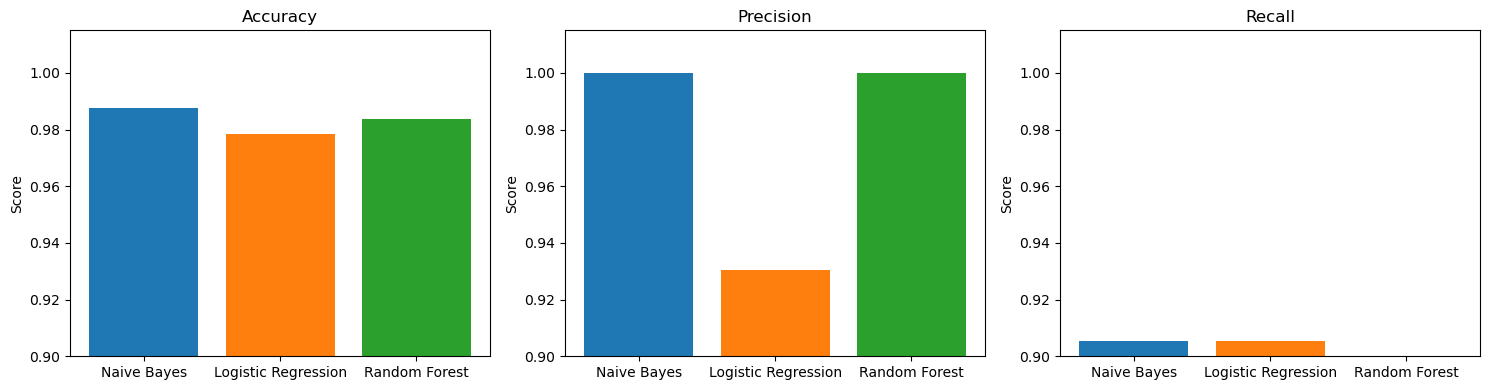

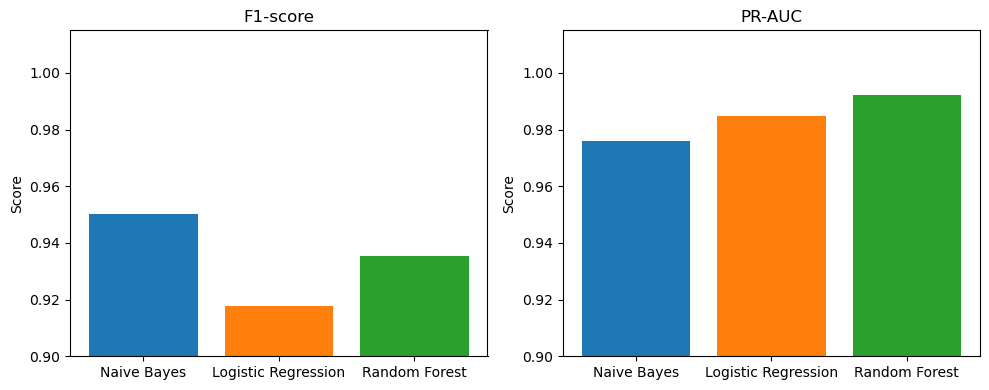

In [179]:
plot_benchmark_histograms(benchmark_df)

### **Sample Prediction**

In [180]:
sample_df = test_df.sample(n=10)

nb_preds = NB_model.best_estimator_.predict(sample_df['message'])
lr_preds = LR_model.best_estimator_.predict(sample_df['message'])
rf_preds = RF_model.best_estimator_.predict(sample_df['message'])

comparison_df = pd.DataFrame({
    "Index": sample_df.index,
    "Original Label": sample_df['label'].values,
    "Naive Bayes": nb_preds,
    "Logistic Regression": lr_preds,
    "Random Forest": rf_preds
})
label_map = {0: "ham", 1: "spam"}
result_df = comparison_df.replace(label_map)

def highlight_mismatches(row):
    styles = [''] * len(row)
    true_label = row["Original Label"]

    for i, col in enumerate(row.index):
        if col in ["Naive Bayes", "Logistic Regression", "Random Forest"]:
            if row[col] != true_label:
                styles[i] = 'color: red; font-weight: bold'
    return styles


styled_df = result_df.style.apply(highlight_mismatches, axis=1)
styled_df


,Index,Original Label,Naive Bayes,Logistic Regression,Random Forest
0,111,ham,ham,ham,ham
1,379,ham,ham,ham,ham
2,367,ham,ham,ham,ham
3,364,ham,ham,ham,ham
4,544,ham,ham,ham,ham
5,557,ham,ham,ham,ham
6,12,ham,ham,ham,ham
7,164,spam,spam,spam,spam
8,218,ham,ham,ham,ham
9,153,spam,spam,spam,spam


## **AUCPR for All 3 Models**

In [181]:
client = MlflowClient()
experiment = client.get_experiment_by_name("Spam_Classification_Benchmarks")
runs = client.search_runs(experiment.experiment_id)

# Sort by seed first, then model name
runs_sorted = sorted(
    runs,
    key=lambda r: (
        int(r.data.params.get("split_seed", 0)),
        r.data.params.get("model_type", "")
    )
)

for run in runs_sorted:
    print(
        "Seed:", run.data.params.get("split_seed"),
        "| Model:", run.data.params.get("model_type"),
        "| AUCPR:", run.data.metrics.get("AUCPR")
    )

Seed: 2 | Model: LogisticRegression | AUCPR: 0.97175431815558
Seed: 2 | Model: NaiveBayes | AUCPR: 0.9728263086278922
Seed: 2 | Model: RandomForest | AUCPR: 0.9781009152192558
Seed: 9 | Model: LogisticRegression | AUCPR: 0.9801250965810162
Seed: 9 | Model: NaiveBayes | AUCPR: 0.9826683697267617
Seed: 9 | Model: RandomForest | AUCPR: 0.9850586293632206
Seed: 13 | Model: LogisticRegression | AUCPR: 0.9877855113882549
Seed: 13 | Model: NaiveBayes | AUCPR: 0.9885968392733478
Seed: 13 | Model: RandomForest | AUCPR: 0.9861198900960066
Seed: 42 | Model: LogisticRegression | AUCPR: 0.9728877411562702
Seed: 42 | Model: NaiveBayes | AUCPR: 0.9730717915123795
Seed: 42 | Model: RandomForest | AUCPR: 0.9790089815699025
Seed: 123 | Model: LogisticRegression | AUCPR: 0.9821824800538023
Seed: 123 | Model: NaiveBayes | AUCPR: 0.9821585310264884
Seed: 123 | Model: RandomForest | AUCPR: 0.9852797370668619
